In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Have all needed imports in one cell

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import evaluate
from datasets import load_dataset
from datasets import Dataset
from evaluate import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F


In [ ]:
# Load data, have it in a dataframe and a dataset form

dataset = load_dataset("ealvaradob/phishing-dataset", "texts", trust_remote_code=True)
df = dataset['train'].to_pandas()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset, test_dataset = Dataset.from_pandas(train_df), Dataset.from_pandas(test_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

phishing-dataset.py:   0%|          | 0.00/3.27k [00:00<?, ?B/s]

texts.json:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Load tokenizer and model, then tokenize the dataset

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16109 [00:00<?, ? examples/s]

Map:   0%|          | 0/4028 [00:00<?, ? examples/s]

In [ ]:
# Define the data collator and the evaluation metrics

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)

    # Calculate Confusion Matrix to get False Positive Rate
    conf_matrix = confusion_matrix(labels, predictions)
    t_neg, f_pos, f_neg, t_pos = conf_matrix.ravel()
    f_pos_rate = f_pos / (f_pos + t_neg)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "fpos_rate": f_pos_rate
    }

In [ ]:
# Set up Training Args and Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

<ipython-input-11-e856c5f8fe62>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
tokenized_train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 16109
})

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Fpos Rate
1,0.134900,0.057627,0.986842,0.988786,0.976547,0.006819
2,0.038400,0.055387,0.988580,0.986283,0.983713,0.008424
3,0.014100,0.054604,0.990318,0.992105,0.982410,0.004813


TrainOutput(global_step=3021, training_loss=0.062442808583729, metrics={'train_runtime': 1069.9205, 'train_samples_per_second': 45.169, 'train_steps_per_second': 2.824, 'total_flos': 1.271536797238272e+16, 'train_loss': 0.062442808583729, 'epoch': 3.0})

In [ ]:
# # Make some plots about the Training accuracy over epochs and Loss over epochs

# acc_percentage = [acc * 100 for acc in accuracies]

# # Plotting Accuracy over Epochs with modified axes
# plt.figure(figsize=(6, 5), dpi=300)
# plt.plot(epochs, accuracies_percentage, marker='o', color='b', label="Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy (%)")
# plt.title("Training Accuracy over Epochs")
# plt.xticks([1, 2, 3])  # Set x-axis to show 1, 2, 3
# plt.legend()
# plt.savefig('acuracy.jpg')
# plt.show()

# # Plotting Loss over Epochs with modified axes
# plt.figure(figsize=(6, 5), dpi=300)
# plt.plot(epochs, losses, marker='o', color='r', label="Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss (%)")
# plt.title("Training Loss over Epochs")
# plt.xticks([1, 2, 3])  # Set x-axis to show 1, 2, 3
# plt.legend()
# plt.savefig('loss.jpg')
# plt.show()

In [ ]:
# Save the model and tokenizer
output_dir = "./finetuned_roberta_model_v3"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./finetuned_roberta_model_v3/tokenizer_config.json',
 './finetuned_roberta_model_v3/special_tokens_map.json',
 './finetuned_roberta_model_v3/vocab.json',
 './finetuned_roberta_model_v3/merges.txt',
 './finetuned_roberta_model_v3/added_tokens.json')

In [ ]:
# Load the model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

# Put in Eval mode
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Make predictions for each sample, also save the confidence scores for each to append to dataset later on

tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

all_pred = []
all_label = []
all_confidence = []

with torch.no_grad():
    for batch in tokenized_test_dataset:
        input_ids = batch["input_ids"].unsqueeze(0)
        attention_mask = batch["attention_mask"].unsqueeze(0)
        labels = batch["label"]

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        out_logits = outputs.logits

        # Calculate probabilities using softmax
        probs = F.softmax(out_logits, dim=1)
        confidence = probs[0,1].item()

        # Store predictions and confidence scores
        pred = torch.argmax(probs, dim=1).item()
        all_pred.append(pred)
        all_confidence.append(confidence)
        all_label.append(labels.item())


In [ ]:
# Print a few results
for i, (text, label, confidence) in enumerate(zip(tokenized_test_dataset["text"], all_label, all_confidence)):
    if i >= 10:
      break

    print(f"Example {i + 1}:")
    print(f"Text: {text}")
    print(f"True Label: {label}")
    print(f"Confidence (Phishing): {confidence}")
    # print(f"Logit Values: {logit_val}")
    print("-" * 50)

Example 1:
Text: 
Digital Dispatch Weekly NewsletterAll CNET
 The Web
Â 
Apple to expand iMac LCD display
It ain't heavy; it's my laptop
Gateway touts chic yet cheap PCs
Apple's iPod comes to Linux
Dell PCs coming to a mall near youMore CNET NewsQuintessential Player 3.4AI Picture Utility 6.2.1ICQ 2002a Build #3728Deck 3.5 (for the Mac)Dell Latitude C510/C610 seriesÂ 
In HardwareToshiba Pocket PC e310 
In ElectronicsAutoCAD LT 2002 
In SoftwareSony Ericsson T68 
In Wireless
 July 11, 2002						--Janice Chen,						editor in chief,						CNET Reviews
 Dear readers,It was a crushing blow to discover that Vindigo, my
all-time-favorite Palm app, was no longer free. Twenty-five bucks
wasn't steep, but the principle of paying for a former freebie
was hard to swallow. Not that hard, though; surprising
myself--and my fellow cheapskates--I've discovered that I'd
rather dish out the dough than go Vindigo-free myself.That's what Web-based e-mail providers are banking on. Now that
most of us have go

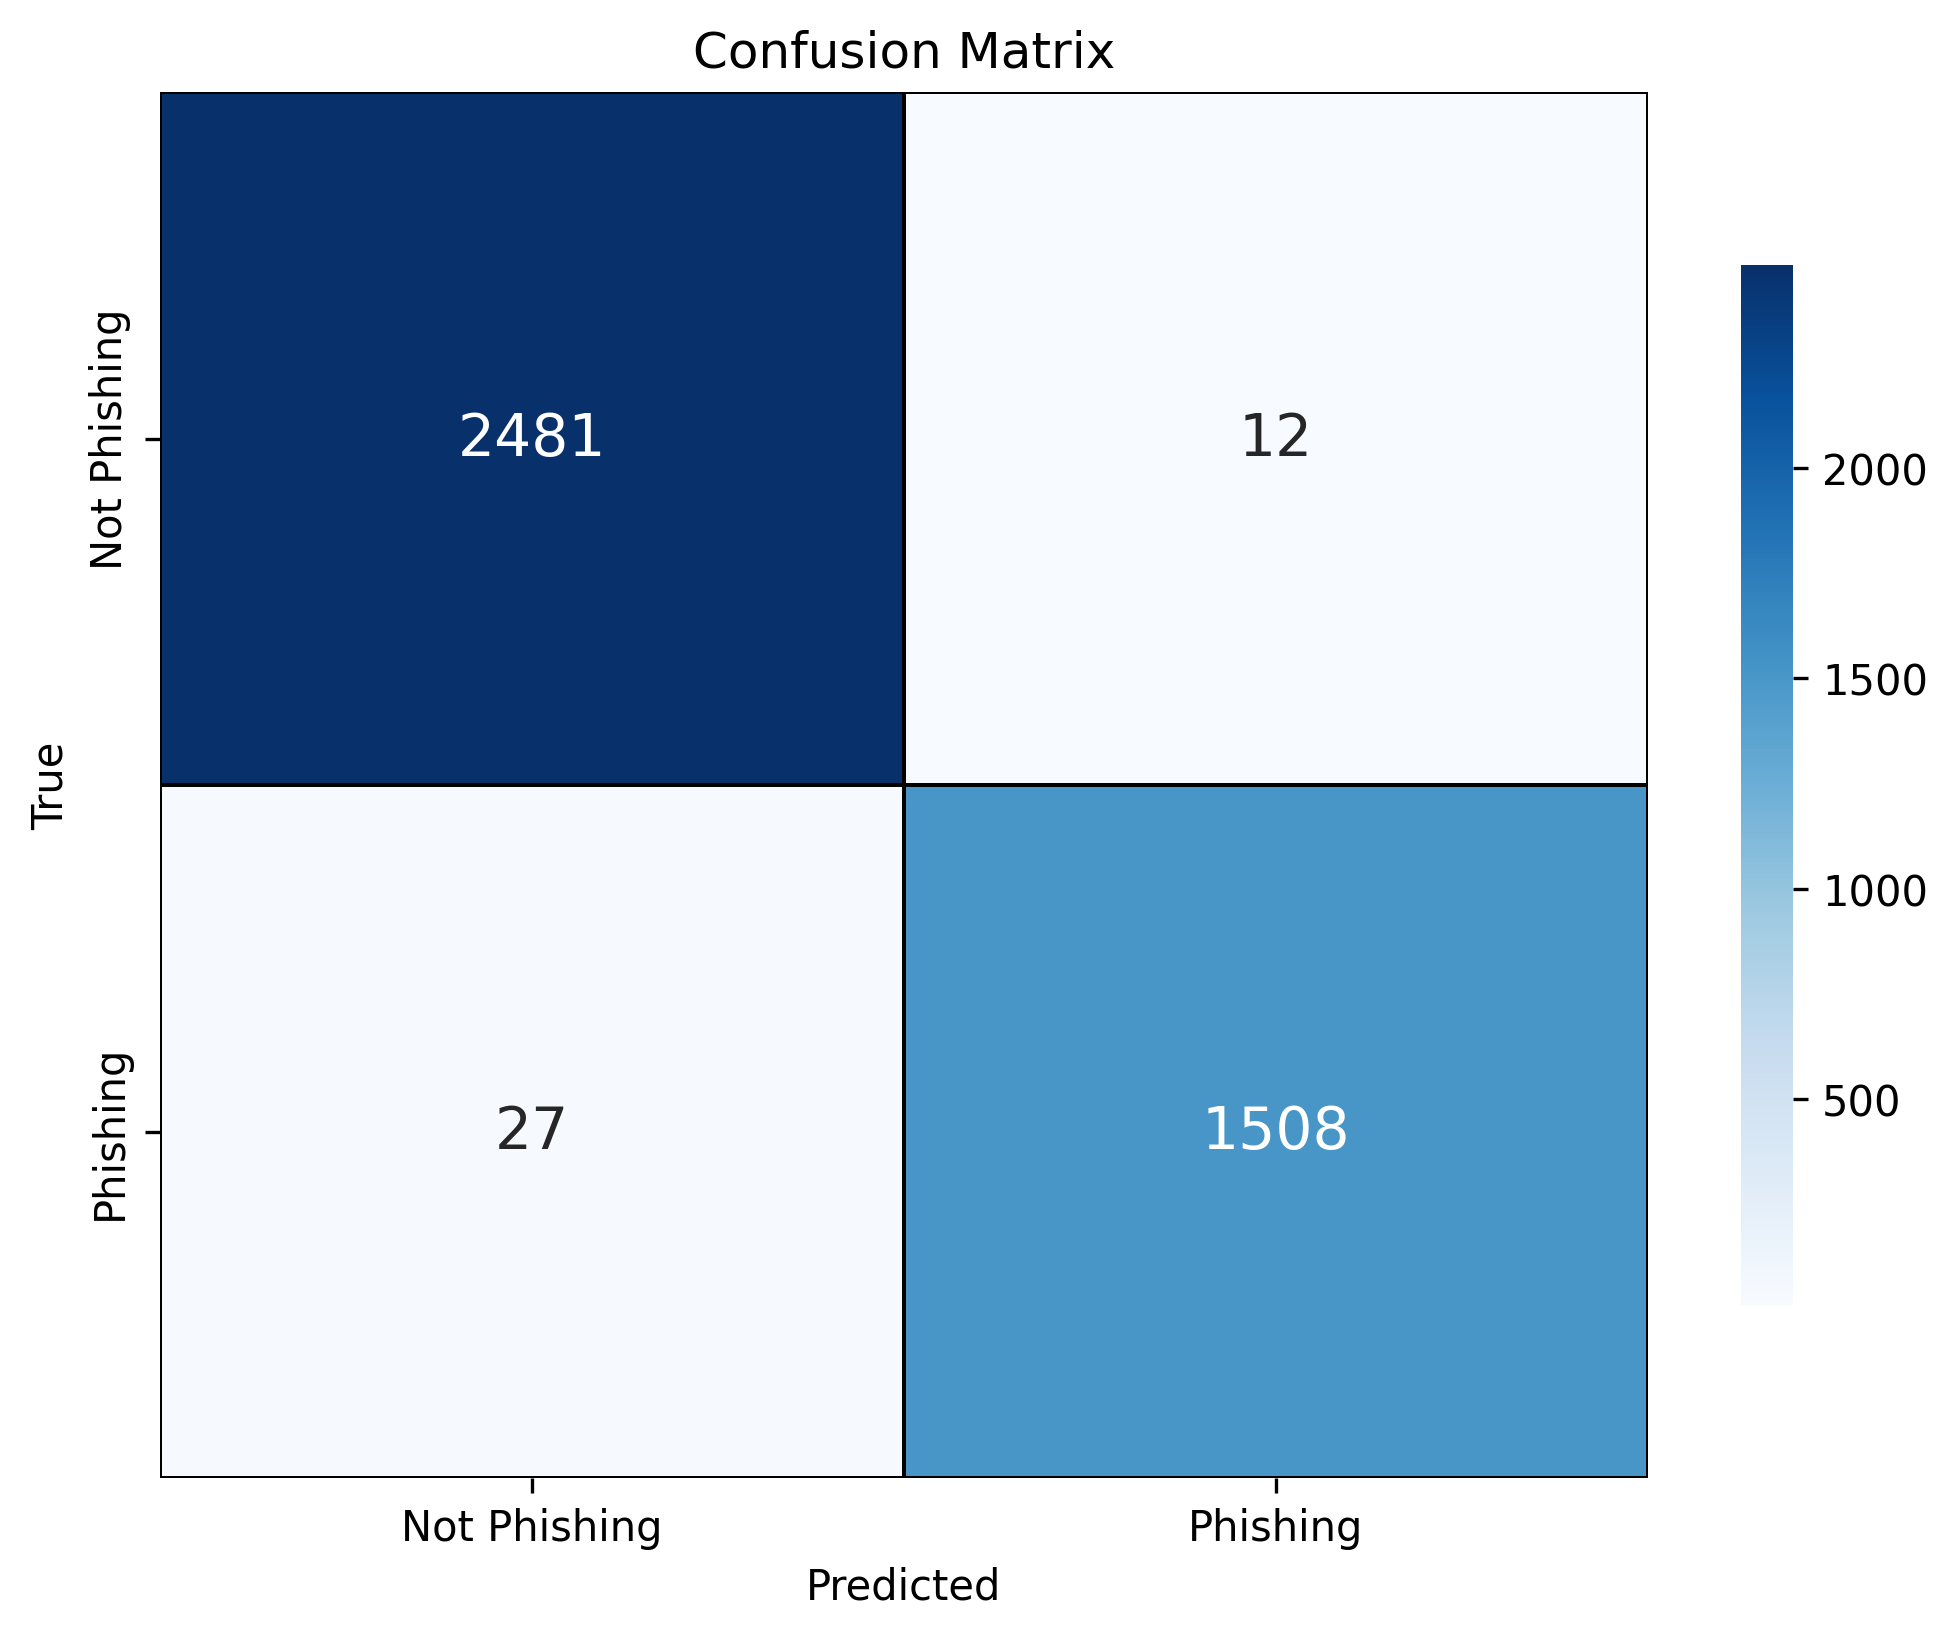

In [ ]:
# Generate confusion matrix

conf_matrix = confusion_matrix(all_label, all_pred)

# Use seaborn heatmap
plt.figure(figsize=(8,6), dpi=300)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Phishing", "Phishing"],
    yticklabels=["Not Phishing", "Phishing"],
    linewidths=0.5,
    linecolor="black",
    cbar_kws={'shrink': .75},
    annot_kws={'size': 14}
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.jpg')
plt.show()

In [ ]:
# We want to create a df with the original text and label, add columns for the Roberta_label and confidence

# Create a DataFrame with original text, label, Roberta_label, and confidence
results_df = pd.DataFrame({
    'text': tokenized_test_dataset["text"],
    'label': all_label,
    'Roberta_label': all_pred,
    'confidence': all_confidence
})

# Print the first few rows of the DataFrame
results_df.head(10)

,text,label,Roberta_label,confidence
0,\nDigital Dispatch Weekly NewsletterAll CNET\n...,0,0,0.000505
1,> Check it into the spambayes project. SF's d...,0,0,0.000037
2,I am in a marriage function,0,0,0.000084
3,re : requests for help thanks vince .,0,0,0.000057
4,URL: http://scriptingnews.userland.com/backiss...,0,0,0.000047
5,global octanes finished visiting with counsel ...,0,0,0.000046
6,From: Win Treese \n> And Owen replied:\n> > We...,0,0,0.000038
7,wicked d $ rugs to keep you going welcome ! it...,1,1,0.999943
8,I seem to be having a little trouble with it....,0,0,0.000037
9,I'm on the bus. Love you,0,0,0.000131


In [ ]:
# Get the size of the results
results_df.shape

(4028, 4)

In [ ]:
results_df["label"].value_counts()

,count
label,
0,2493
1,1535


In [ ]:
# New imports for the commonality score
import requests
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import csv
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

In [ ]:
nlp = spacy.load('en_core_web_sm')

url = "https://wordsapiv1.p.rapidapi.com/words/{word}"
headers = {
    'x-RapidAPI-Key': "fbc51cbe2amsh1526fa2e0576cadp163480jsn7a8db0397fc4",
    'x-RapidAPI-Host': "wordsapiv1.p.rapidapi.com"
}

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt_tab')

def sentence_preprocessing(sentence):
    doc = nlp(sentence)

    # Lemmatization
    # lemmatized_words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # named_entities = {ent.text: ent.label_ for ent in doc.ents}

    keywords = [token.text for token in doc if token.pos_ in {"NOUN", "VERB", "PROPN"} and not token.is_stop]

    # We are having trouble with the API calls taking to long, so we are limiting the number of keywords that will be called
    # Sort by length of keywords so longer, more unique words will be counted in case of too many keywords
    keywords = sorted(keywords, key=len, reverse=True)
    keywords = keywords[:5]
    return keywords

    # return {
    #     "lemmatized_words": lemmatized_words,
    #     "named_entities": named_entities,
    #     "keywords": keywords
    # }

def get_word_info(word):
    response = requests.get(url.format(word=word), headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return {}

def analyze_sentence(sentence):
    # Tokenize the sentence, remove stopwords, and non-alphabetic words
    stop_words = set(stopwords.words('english'))

    # word_tokenize just removed stopwords and numbers, so we switched to sentence_preprocessing to only get keywords
    # tokens = word_tokenize(sentence)
    tokens = sentence_preprocessing(sentence)
    # total_words = len(tokens)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and token.isalpha()]

    # Fetch information on each word
    zipf_scores = []
    for token in filtered_tokens:
        word_info = get_word_info(token)
        if 'frequency' in word_info:
            zipf_scores.append(word_info['frequency'])
        else:
            zipf_scores.append(0)

    avg_zipf_score = sum(zipf_scores) / len(zipf_scores) if zipf_scores else 0

    commonality_score = 1 / (avg_zipf_score + 1) if avg_zipf_score else 0
    adjusted_score = 1 - commonality_score
    print(f"Finished a sentence")
    # INDEX += 1

    return {
        "avg_zipf_score": avg_zipf_score,
        "commonality_score": commonality_score,
        "adjusted_score": adjusted_score
    }

In [ ]:
phish_df = results_df

In [ ]:
sub_set = phish_df.sample(n=10)
sub_set_results = sub_set['text'].apply(analyze_sentence).apply(pd.Series)
sub_set_results.head()

Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence


,avg_zipf_score,commonality_score,adjusted_score
410,2.997000,0.250188,0.749812
466,3.812593,0.207788,0.792212
869,3.437143,0.225370,0.774630
884,3.990000,0.200401,0.799599
1262,3.949667,0.202034,0.797966


In [ ]:
sub_set = pd.concat([sub_set, sub_set_results], axis=1)
sub_set.head(10)

,text,label,Roberta_label,confidence,avg_zipf_score,commonality_score,adjusted_score
410,\n Ã¿FFFFA9\nCopyright 2002 - All rights reser...,1,1,0.999914,2.997000,0.250188,0.749812
466,Pack Your Bags!Congratulations!\nOfficial\n ...,1,1,0.999920,3.812593,0.207788,0.792212
869,yahoo - transwestern pipeline announces succes...,0,0,0.000228,3.437143,0.225370,0.774630
884,"on his face , framed hello , our bank has appr...",1,1,0.999944,3.990000,0.200401,0.799599
1262,"hello all , the program for the 2000 texas fin...",0,0,0.000040,3.949667,0.202034,0.797966
2749,URL: http://boingboing.net/#85524823\nDate: No...,0,0,0.000067,2.050000,0.327869,0.672131
1111,non - lexical semantics apologies for multiple...,0,0,0.000051,3.207000,0.237699,0.762301
564,PRIVATE! Your 2003 Account Statement for <fone...,1,1,0.999940,3.652222,0.214951,0.785049
2887,Dear Sir / MadamIf you are fed up of being 'ri...,1,1,0.999807,3.815600,0.207658,0.792342
3576,Hi mate its RV did u hav a nice hol just a mes...,0,0,0.000100,3.528333,0.220832,0.779168


In [ ]:
sub_set.groupby('label')["commonality_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5.0,0.242761,0.049272,0.202034,0.220832,0.225370,0.237699,0.327869
1,5.0,0.216197,0.019685,0.200401,0.207658,0.207788,0.214951,0.250188


In [ ]:
sub_set.groupby('label')["avg_zipf_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5.0,3.234429,0.714609,2.050,3.207000,3.437143,3.528333,3.949667
1,5.0,3.653483,0.385945,2.997,3.652222,3.812593,3.815600,3.990000


In [ ]:
sub_set.groupby('label')["adjusted_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5.0,0.757239,0.049272,0.672131,0.762301,0.774630,0.779168,0.797966
1,5.0,0.783803,0.019685,0.749812,0.785049,0.792212,0.792342,0.799599


In [ ]:
subset_label_0 = phish_df[phish_df['label'] == 0]
subset_label_1 = phish_df[phish_df['label'] == 1]

num_per_group = 50

sampled_label_0 = subset_label_0.sample(n=num_per_group, random_state=42)
sampled_label_1 = subset_label_1.sample(n=num_per_group, random_state=42)

# our_subset = pd.concat([sampled_label_0, sampled_label_1]).sample(frac=1, random_state=42)
our_subset = pd.concat([sampled_label_0, sampled_label_1])
our_subset.head(10)

,text,label,Roberta_label,confidence
3559,fw : victoria storey ' s baby - - - - - origin...,0,0,0.000050
3333,Dont flatter yourself... Tell that man of mine...,0,0,0.000069
2234,re : www . energyclear . com i didn ' t see th...,0,0,0.000033
3457,:-( that's not v romantic!,0,0,0.000056
1699,maple leaf attendees below is a list of maple ...,0,0,0.000093
4006,re : 5 . 1254 typological classification for w...,0,0,0.000034
3067,"re : industrials robert , how do we look on th...",0,0,0.000031
1290,There is a whitelist RBL now! Ironport's Bond...,0,0,0.000046
1374,weekly status update for gtv please see below ...,0,0,0.000036
3077,"policy and politics news website hey guys , in...",0,0,0.000466


In [ ]:
# sampled_label_0.shape
# sampled_label_1.shape
our_subset["label"].value_counts()
# subset_label_1["label"].value_counts()
# sampled_label_1["label"].value_counts()

,count
label,
0,50
1,50


In [ ]:
our_subset = phish_df.sample(n=100)
our_subset_results = our_subset['text'].apply(analyze_sentence).apply(pd.Series)
our_subset = pd.concat([our_subset, our_subset_results], axis=1)

Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence
Finished a sentence


In [ ]:
# our_sub_set = pd.concat([sub_set, our_sub_set_results], axis=1)
our_subset.head(10)

,text,label,Roberta_label,confidence,avg_zipf_score,commonality_score,adjusted_score
3033,keep your memories alive with a free canon dig...,1,1,0.999930,4.250000,0.190476,0.809524
2032,This University Degree Program removes the obs...,1,1,0.999916,3.257500,0.234880,0.765120
2461,When you guys planning on coming over?,0,0,0.000121,5.350000,0.157480,0.842520
3053,re : request submitted : access request for je...,0,0,0.000036,2.846000,0.260010,0.739990
1327,fw : 8743 meter set up ; fac # 501869 i have a...,0,0,0.000030,2.588000,0.278707,0.721293
1900,Adam Beberg:\n>Considering 90% of the fake job...,0,0,0.000040,2.894000,0.256805,0.743195
1179,use Perl Daily Headline MailerThis Week on per...,0,0,0.000091,2.173333,0.315126,0.684874
1487,unbelievable loans for the usa ! if you consid...,1,1,0.999929,1.792000,0.358166,0.641834
88,fw : fyi - - - - - original message - - - - - ...,0,0,0.000032,1.516000,0.397456,0.602544
1679,\tUR GOING 2 BAHAMAS! CallFREEFONE 08081560665...,1,1,0.999949,2.840000,0.260417,0.739583


In [ ]:
our_subset.groupby('label')["commonality_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,0.208153,0.096610,0.0,0.186081,0.227894,0.261370,0.397456
1,35.0,0.252468,0.156496,0.0,0.201536,0.234880,0.305449,0.658762


In [ ]:
our_subset.groupby('label')["avg_zipf_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,2.860987,1.427910,0.0,2.342,3.07,3.704,5.350
1,35.0,2.428319,1.456102,0.0,1.510,2.84,3.499,4.854


In [ ]:
our_subset.groupby('label')["adjusted_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,0.791847,0.096610,0.602544,0.738630,0.772106,0.813919,1.0
1,35.0,0.747532,0.156496,0.341238,0.694551,0.765120,0.798464,1.0


In [ ]:
# # Apply analyze_sentence to the 'text' column and create new columns
# results = phish_df['text'].apply(analyze_sentence).apply(pd.Series)

# # Concatenate the results with the original DataFrame
# phish_df = pd.concat([phish_df, results], axis=1)

In [ ]:
our_subset.to_csv('results_keywords5.csv', index=False)

In [ ]:
# Create a copy of our_subset
our_subset_copy = our_subset.copy()

# Normalize the last three columns ('avg_zipf_score', 'commonality_score', 'adjusted_score')
cols_to_normalize = ['avg_zipf_score', 'commonality_score', 'adjusted_score']
our_subset_copy[cols_to_normalize] = (our_subset_copy[cols_to_normalize] - our_subset_copy[cols_to_normalize].min()) / (our_subset_copy[cols_to_normalize].max() - our_subset_copy[cols_to_normalize].min())

In [ ]:
our_subset_copy.groupby('label')["commonality_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,0.315976,0.146654,0.0,0.282471,0.345943,0.396759,0.603339
1,35.0,0.383246,0.237561,0.0,0.305932,0.356547,0.463672,1.000000


In [ ]:
our_subset_copy.groupby('label')["avg_zipf_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,0.534764,0.266899,0.0,0.437757,0.573832,0.692336,1.00000
1,35.0,0.453891,0.272169,0.0,0.282243,0.530841,0.654019,0.90729


In [ ]:
our_subset_copy.groupby('label')["adjusted_score"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,65.0,0.684024,0.146654,0.396661,0.603241,0.654057,0.717529,1.0
1,35.0,0.616754,0.237561,0.000000,0.536328,0.643453,0.694068,1.0


In [ ]:
our_subset_copy.to_csv('normalized_results_keywords5.csv', index=False)

FOR SCORES:

Common words have a higher zipf score then uncommon words. When adjusted to 0-1 scale in the commonality score, they end up having the higher value then